## **Εξαγωγή χαρακτηριστηκών ήχου**

**Άλλα φασματικά χαρακτηριστικά**



In [35]:
#Εισαγωγή βιβλιοθηκών

import librosa
import sklearn
import librosa.display
import math
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal

In [2]:
#Αρχικοποίηση μήκους πλαισίου,μήκους βήματος 
FRAME_SIZE=2048 
HOP_LENGTH=256

#Όταν το βήμα είναι μισό του μήκους πλαισίου έχουμε 50% επικάλυψη πλαισίων

> H βιβλιοθήκη [librosa](https://librosa.org/doc/latest/index.html) μας δίνει την δυνατότητα να φορτώσουμε ένα αρχείο ήχου με την εντολή [librosa.load](https://librosa.org/doc/main/generated/librosa.load.html) συναρτήσει του χρόνου.

Για την ανάγνωση αρχείων στο Google Collab προτείνεται η διαδικασία που φαίνεται εδώ: https://neptune.ai/blog/google-colab-dealing-with-files

In [3]:
#Αρχικοποίηση αρχείων/δειγμάτων
file_path=("/content/piano C#.wav")
audio_sample, sr =librosa.load(file_path)

Για την εξυπηρέτηση των αναγκών της εγασίας αυτής, προτιμήθηκε η χρήση αρχείων μικρής διάρκειας και μίας νότας. 

*Αν θέλαμε να φορτώσουμε κάποιο δοκιμαστικό αρχείο ήχου από την βιλβιοθήκη librosa :*


```
filename= librosa.ex('trumpet')
audio_sample, sr =librosa.load(filename)

```











> Στην συνέχεια μπορούμε να αναπαράγουμε το σήμα μέσω της βιβλιοθήκης [IPython](https://ipython.org/).



In [4]:
#Αναπαραγωγή ήχου
ipd.Audio(data=audio_sample,rate=sr)

## Chroma Grams ##




> Υπολογισμός διαγραμμάτων Chroma με την βιβλιοθήκη [librosa](https://librosa.org/doc/0.9.1/index.html). 

> Για πηγαίο κώδικα [librosa.feature.chroma_stft](https://librosa.org/doc/0.9.1/generated/librosa.feature.chroma_stft.html?highlight=chroma_stft#librosa.feature.chroma_stft)







In [5]:
# Υπολογισμός chromagram και αποθήκευση πίνακα σε μεταβλητή
chromagram = librosa.feature.chroma_stft(audio_sample, sr=sr, hop_length=HOP_LENGTH)

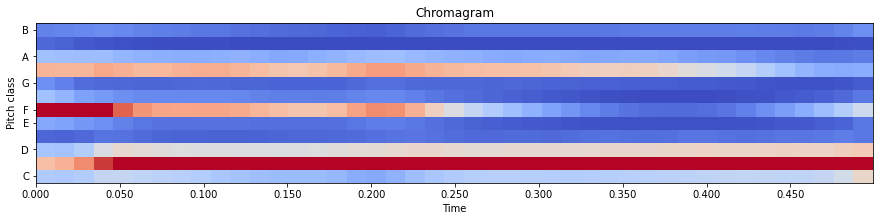

In [6]:
# Γράφημα chroma gram
plt.figure(figsize=(15, 10))
ax = plt.subplot(3, 1, 1)
plt.title("Chromagram")
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=HOP_LENGTH, cmap='coolwarm')


##  Band Energy Ratio ##

Ο υπολογισμός του λόγου ενέργειας μεταξύ υψηλών και χαμηλών συχνοτήτων υπολογίζεται από το φασματογράφημα (spectrogram). Συνεπώς:

In [7]:
S_audio_sample= librosa.stft(audio_sample,n_fft=FRAME_SIZE,hop_length=HOP_LENGTH)

Ο λόγος ενέργειας μεταξύ υψηλών και χαμηλών συχνοτήτων δίνεται από τον τύπο: 

$$\frac{\sum_{n=1}^{F-1} m t(n))^2}{\sum_{n=F}^{N} m t(n))^2}$$


με F να αποτελεί το συχνοτικό κατώφλι των δύο ζωνών. Όλες οι συχνότητες κάτω από το κατώφλι αυτό θεωρούνται χαμηλές, ενώ όλες οι συχνότητες πάνω από το κατώφλι υψηλές. 

*Στο σημείο αυτό υπενθυμίζουμε πως στον ψηφιακό κόσμο οι συχνότητες είναι διακριτές. Συνεπώς δεν μπορούμε να δώσουμε μια οποιαδήποτε συχνότητα ως συχνότητα F. Για τον υπολογισμό της συχνότητας F δίνεται παρακάτω η συνάρτηση calculate_split_frequency_bin.*





> Παρατειρώντας τις διαστάσεις του πίνακα του φασματογραφήματος βλέπουμε πως το πλήθος συχνοτικών περιοχών είναι 257.





In [8]:
S_audio_sample.shape

(1025, 43)

In [9]:
def calculate_split_frequency_bin(spectrogram,split_frequency, sample_rate):
    # H μεγαλύτερη συχνότητα που περιέχεται στο φασματογράφημα είναι η συχνότητα Nyquist
    frequency_range = sample_rate / 2

    # Αυτό το συχνότικό εύρος είναι διαχωρισμένο σε συχνότικές ομάδες (257 σύμφωνα με το τις διαστάσεις του φασματογραφήματος)
    frequency_delta_per_bin = frequency_range / spectrogram.shape[0]

    # Άρα η μεταβολή η συχνότητα διαχωρισμού μετά την μεταβολή της εντός της συχνότικής ομάδας
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [18]:
split_frequency_bin = calculate_split_frequency_bin(S_audio_sample, 2000, sr)
split_frequency_bin

185

Άρα η συχνότητα 2000Ηz βρίσκεται στην συχνότική ομάδα (frequency bin) 46.

In [19]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(spectrogram,split_frequency,sample_rate)
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame =  sum_power_low_frequencies/ sum_power_high_frequencies
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

In [24]:
ber_audio_sample = band_energy_ratio(S_audio_sample, 300, sr)

In [25]:
# Όπως περιμέναμε, ο πίνακας του λόγου χαμηλών-υψηλών συχνοτήτων περιέχει 43 τιμές
# όσες η δεύτερη διάσταση (χρόνος) του φασματογραφήματος
ber_audio_sample.shape

(43,)

In [56]:
# Συχνότητα κανονικοποίησης για την γραφική αναπαράσταση
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

In [28]:
# Μετατροπή των πλαισίων σε χρόνο και γραφική αναπαράσταση του λόγου συχνότικών περιοχών ως προς το χρόνο 
frames = range(len(ber_audio_sample))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

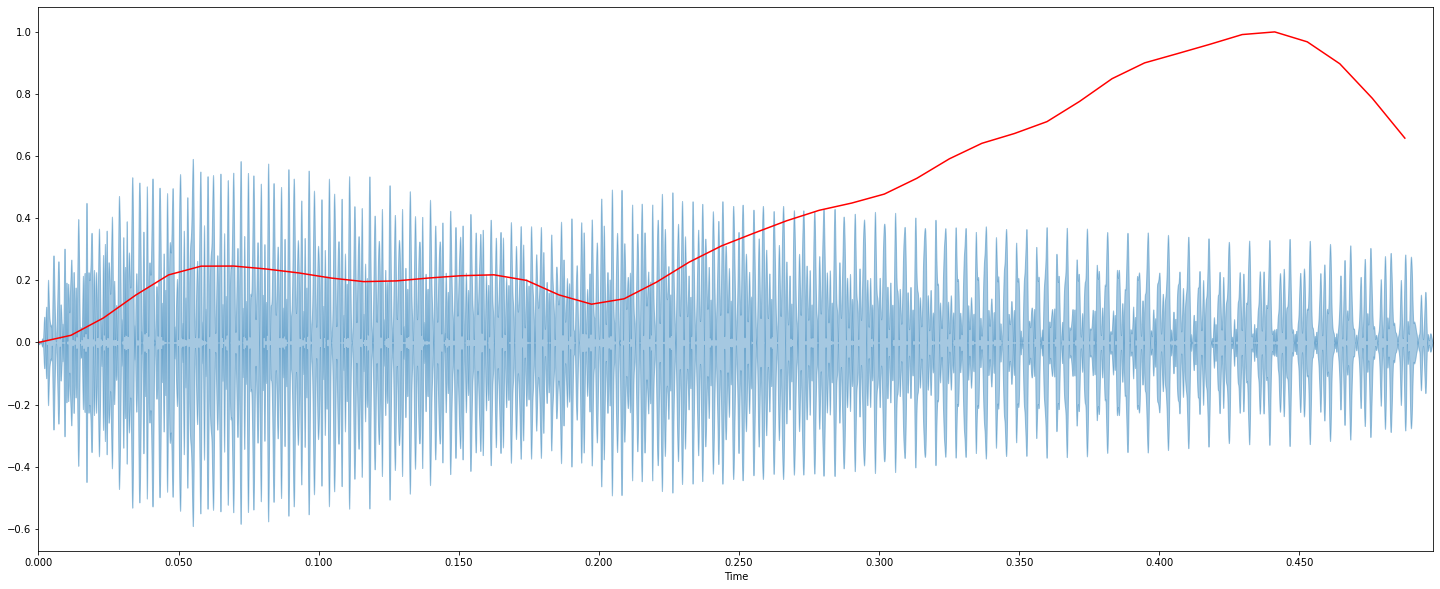

In [43]:
plt.figure(figsize=(25, 10))
librosa.display.waveplot(audio_sample, sr=sr, alpha=0.4)
plt.plot(t, normalize(ber_audio_sample), color="r")
plt.show()

## Spectral Centroid ##

Το **φασματικό κέντρο** μας δείχνει την συχνότητα γύρω από την οποία βρίκσεται συγκεντρωμένη η περισσότερη ενέργεια. Δίνεται από τον τύπο:

$$ f_c = \frac{\sum_k S(k) f(k)}{\sum_k S(k)} $$

όπου $S(k)$ το πλάτος της συχνότικής περιοχής $k$, $f(k)$ η συχνότητα της περιοχής $k$.



> Ο υπολογισμό γίνεται μέσω της βιβλιοθήκης **librosa**. Για πηγαίο κώδικα: [librosa.feature.spectral_centroid](https://librosa.org/doc/0.9.1/generated/librosa.feature.spectral_centroid.html) 

In [47]:
sc_audio_sample = librosa.feature.spectral_centroid(y=audio_sample, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

In [48]:
# Μετατροπή των πλαισίων σε χρόνο και γραφική αναπαράσταση φασματικού κέντρου
frames = range(len(sc_audio_sample))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

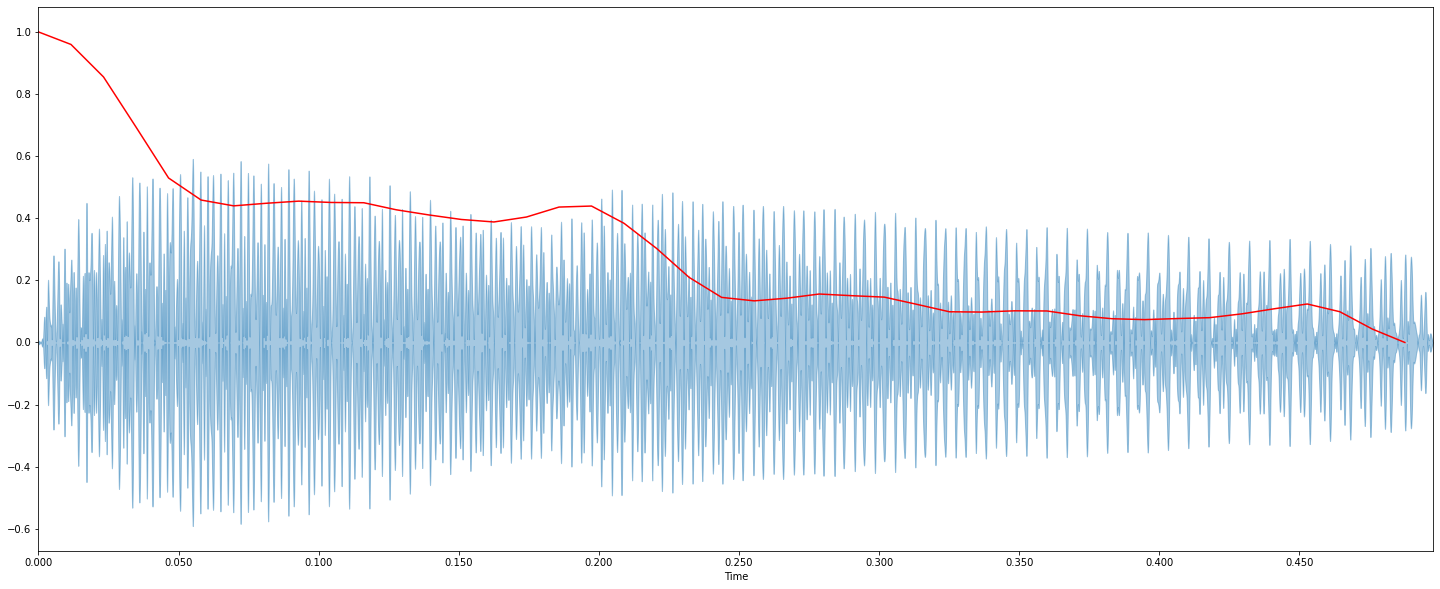

In [49]:
plt.figure(figsize=(25,10))
librosa.display.waveplot(audio_sample, sr=sr, alpha=0.4)
plt.plot(t, normalize(sc_audio_sample), color='r')

plt.show()

## Spectral Bandwidth ##

To φασματικό εύρος ζώνης δίνεται από τον τύπο 
$$ \left( \sum_k S(k) \left(f(k) - f_c \right)^p \right)^{\frac{1}{p}} $$

όπου $S(k)$ το πλάτος της συχνότικής περιοχής $k$, $f(k)$ η συχνότητα της περιοχής $k$ και $f_c$ το φασματικό κέντρο.

> Ο υπολογισμό γίνεται μέσω της βιβλιοθήκης **librosa**. Για πηγαίο κώδικα: [librosa.feature.spectral_bandwidth](https://librosa.org/doc/0.9.1/generated/librosa.feature.spectral_bandwidth.html)

In [50]:
ban_audio_sample= librosa.feature.spectral_bandwidth(y=audio_sample, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

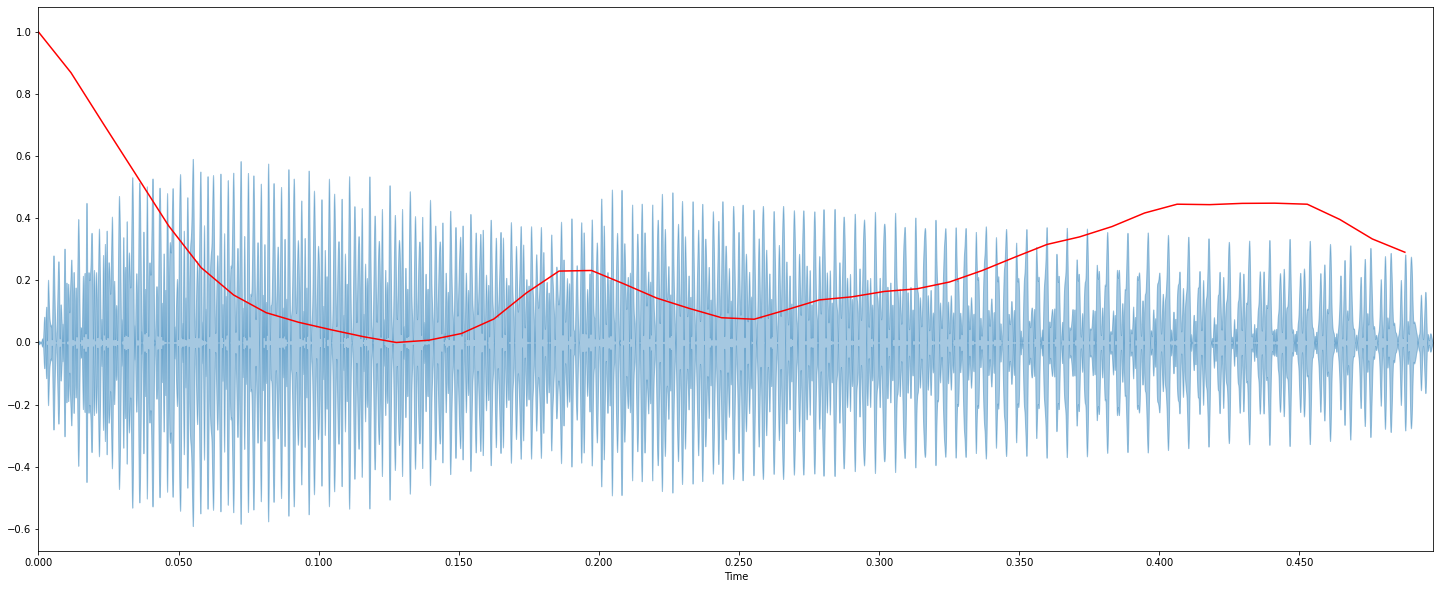

In [55]:
# Γραφική αναπαράσταση φασματικού κέντρου
plt.figure(figsize=(25,10))
librosa.display.waveplot(audio_sample, sr=sr, alpha=0.4)
plt.plot(t, normalize(ban_audio_sample), color='r')
plt.show()